## Regression Analysis for Predicting Soil Thickness
Test run - in development

## Load libraries

In [2]:
# load relevant libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

## Prep/load training data

In [3]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/2-uw_layer1_trainingdata.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30573 47.65672),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30684 47.65364),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30647 47.65377),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30664 47.65326),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30626 47.65371),Qvt,1.996012,9.385303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,143845,MW-1,Geotechnical,42.0,217.4,47.661044,-122.342453,1,0.0,7.5,SM,S,7.5,POINT (-122.34245 47.66104),Qvr,1.594538,10.106370
502,143846,MW-2,Geotechnical,43.0,218.2,47.661138,-122.342516,1,0.0,7.5,SM,S,7.5,POINT (-122.34252 47.66114),Qvr,1.340698,8.735672
503,143847,MW-3,Geotechnical,45.5,219.3,47.661276,-122.342492,1,0.0,18.0,SM,S,18.0,POINT (-122.34249 47.66128),Qvr,1.594538,10.106370
504,143848,MW-4,Geotechnical,43.0,219.1,47.661177,-122.342383,1,0.0,10.0,SM,S,10.0,POINT (-122.34238 47.66118),Qvr,1.594538,10.106370


## Training data, preprocessing, and splits

In [4]:
# Pull training data from dataframe
X = training_data[['MAPPED_UNIT','SLOPE','ROUGHNESS']]
y_1 = training_data['LAYER_THICKNESS_FT']

# Preprocessing to convert MAPPED_UNIT to a usable, non-string format
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), ['MAPPED_UNIT']),  # use OneHotEncoder for categorical features
        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
    ])

# Prepare the preprocessed data to be incorporated into the data split
X_processed = preprocessor.fit_transform(X)

# Handling target for LAYER_THICKNESS_FT
scaler = StandardScaler()
y_1_scaled = scaler.fit_transform(y_1.values.reshape(-1, 1))

# Split the data into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_processed, y_1_scaled, test_size=0.2, random_state=42)

# We need to scale the x variable too, otherwise the data training is very bad
#X_train_scaled = scaler.fit_transform(X_train_1)

print(X_train_1) ## may be an issue here because this gives a sparse row sparse matrix, but we're gonna keep going


[[ 0.          0.          0.         ...  0.          0.0637963
   0.22654039]
 [ 0.          0.          0.         ...  0.          0.24755934
   0.13296444]
 [ 0.          0.          0.         ...  0.          0.343192
   0.35311093]
 ...
 [ 0.          0.          0.         ...  0.          0.39578907
   0.15639789]
 [ 0.          0.          0.         ...  0.         -0.40232824
  -0.2651777 ]
 [ 0.          0.          0.         ...  0.          1.24241092
   1.22029349]]


## Model training

In [5]:
# Define the kernel
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e2))

# # Initialize GaussianProcessRegressor
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)

# Fit the model (scikit-learn handles optimization internally)
gaussian_process.fit(X_train_1, y_train_1)


GaussianProcessRegressor(alpha=1e-06, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

(array([280., 130.,  44.,  16.,  15.,   4.,  12.,   3.,   1.,   1.]),
 array([ 0.2 ,  5.48, 10.76, 16.04, 21.32, 26.6 , 31.88, 37.16, 42.44,
        47.72, 53.  ]),
 <BarContainer object of 10 artists>)

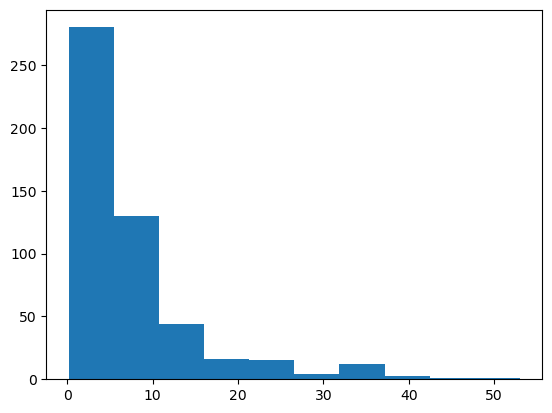

In [9]:
# Make model predictions
gaussian_process.predict(X_test_1, return_std=True)

# Unscale the data for visualizations
pred_unscaled = scaler.inverse_transform(y_1_scaled)

plt.hist(pred_unscaled)
